In [152]:
import pandas as pd
import numpy as np
import pylab
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [138]:
df = sm.datasets.sunspots.load_pandas().data

In [139]:
df['YEAR'] = df['YEAR'].astype(int)

In [140]:
date_index = pd.to_datetime(df['YEAR'], format='%Y')
date_index

0     1700-01-01
1     1701-01-01
2     1702-01-01
3     1703-01-01
4     1704-01-01
         ...    
304   2004-01-01
305   2005-01-01
306   2006-01-01
307   2007-01-01
308   2008-01-01
Name: YEAR, Length: 309, dtype: datetime64[ns]

In [145]:
series = pd.Series(list(df['SUNACTIVITY']), index=date_index)
series = series.asfreq(pd.infer_freq(series.index))
series

YEAR
1700-01-01     5.0
1701-01-01    11.0
1702-01-01    16.0
1703-01-01    23.0
1704-01-01    36.0
              ... 
2004-01-01    40.4
2005-01-01    29.8
2006-01-01    15.2
2007-01-01     7.5
2008-01-01     2.9
Freq: AS-JAN, Length: 309, dtype: float64

<AxesSubplot:xlabel='YEAR'>

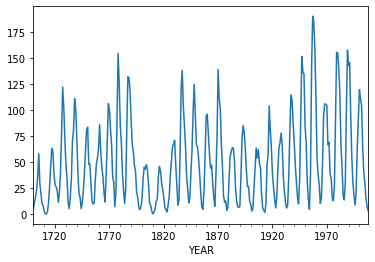

In [146]:
series.plot()

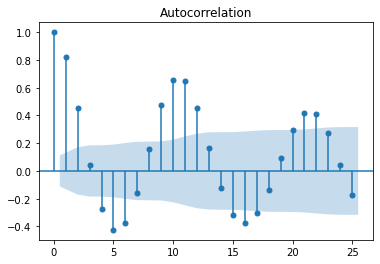

In [147]:
acf_plot = plot_acf(series)

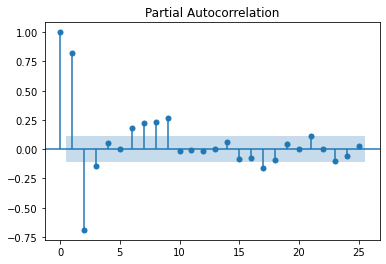

In [148]:
pacf_plot = plot_pacf(series)

In [162]:
model = SARIMAX(series, order=(2, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1340.790
Date:                Thu, 14 Jan 2021   AIC                           2691.581
Time:                        16:39:07   BIC                           2710.248
Sample:                    01-01-1700   HQIC                          2699.044
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1877      0.153      7.758      0.000       0.888       1.488
ar.L2         -0.3443      0.145     -2.373      0.018      -0.629      -0.060
ma.L1          0.3437      0.156      2.206      0.0